In [2]:
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import logging
from scipy.spatial import cKDTree

In [3]:
def proj_selection(projection):
    if projection == "pc":
        projection_ccrs = ccrs.PlateCarree()
    if projection == "mer":
        projection_ccrs = ccrs.Mercator()
    elif projection == "np":
        projection_ccrs = ccrs.NorthPolarStereo()
    elif projection == "sp":
        projection_ccrs = ccrs.SouthPolarStereo()
    return projection_ccrs

def region_cartopy(box, res, projection="pc"):
    """ Computes coordinates for the region 
    Parameters
    ----------
    box : list
        List of left, right, bottom, top boundaries of the region in -180 180 degree format
    res: list
        List of two variables, defining number of points along x and y
    projection : str
        Options are:
            "pc" : cartopy PlateCarree
            "mer": cartopy Mercator
            "np" : cartopy NorthPolarStereo
            "sp" : cartopy SouthPolarStereo
    Returns
    -------
    x : numpy.array
        1 d array of coordinate values along x
    y : numpy.array
        1 d array of coordinate values along y
    lon : numpy.array
        2 d array of longitudes
    lat : numpy array
        2 d array of latitudes
    """
    projection_ccrs = proj_selection(projection)

    if not res is None:
        lonNumber, latNumber = res
    else:
        lonNumber, latNumber = 500, 500
    left, right, down, up = box
    logging.info('Box %s, %s, %s, %s', left, right, down, up)
    fig, ax = plt.subplots(
        1,
        1,
        subplot_kw=dict(projection=projection_ccrs),
        constrained_layout=True,
        figsize=(10, 10),
    )
    ax.set_extent([left, right, down, up], crs=ccrs.PlateCarree())
    xmin, xmax = ax.get_xbound()
    ymin, ymax = ax.get_ybound()

    # res = scl_fac * 300. # last number is the grid resolution in meters (NEEDS TO BE CHANGED)
    # nx = int((xmax-xmin)/res)+1; ny = int((ymax-ymin)/res)+1
    x = np.linspace(xmin, xmax, lonNumber)
    y = np.linspace(ymin, ymax, latNumber)
    x2d, y2d = np.meshgrid(x, y)

    npstere = ccrs.PlateCarree()
    transformed2 = npstere.transform_points(projection_ccrs, x2d, y2d)
    lon = transformed2[:, :, 0]  # .ravel()
    lat = transformed2[:, :, 1]  # .ravel()
    fig.clear()
    plt.close(fig)
   
    return x, y, lon, lat

def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [4]:
# read in fesom output

mesh_path = '/work/ab0995/a270185/meshes/AO_40/'
data_path = '/work/ab0995/a270185/AO_1km_ice/'

year = 2015

mesh = pf.load_mesh(mesh_path)

a_ice = pf.get_data(data_path, 'a_ice', year, mesh, compute=False, how=None)
u_ice = pf.get_data(data_path, 'uice', year, mesh, compute=False, how=None)
v_ice = pf.get_data(data_path, 'vice', year, mesh, compute=False, how=None)

/work/ab0995/a270185/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ab0995/a270185/meshes/AO_40/pickle_mesh_py3_fesom2
Depth is None, 3d field will be returned
Depth is None, 3d field will be returned
Depth is None, 3d field will be returned


In [5]:
# create interpolation grid

box = (-180, 180, 60, 90)
res = (1000, 1000)
proj = 'np'

int_x_steps, int_y_steps, int_lons, int_lats = region_cartopy(box, res, proj)

In [6]:
# read fesom grid

fesom_mesh = xr.open_dataset('/work/ab0995/a270185/meshes/AO_40/fesom.mesh.diag.nc')

model_lons = fesom_mesh.lon.values
model_lats = fesom_mesh.lat.values

nonan = ~(np.isnan(model_lons) | np.isnan(model_lats))
model_lons_nonan = model_lons[nonan]
model_lats_nonan = model_lats[nonan]

In [7]:
# calculate distance to and index of the fesom grid point closest to
# the grid point in the interpolation grid

distances, inds = create_indexes_and_distances(model_lons_nonan, model_lats_nonan,
                                               int_lons, int_lats,
                                               k=1, workers=10)

In [8]:
# set up interpolation arrays

ntimesteps = len(a_ice.time)

a_ice_int = np.zeros((ntimesteps,*np.shape(int_lons)))
u_ice_int = np.zeros_like(a_ice_int)
v_ice_int = np.zeros_like(a_ice_int)

In [9]:
%%time

# interpolate by just using the value of the nearest neighbor

for itime in range(a_ice.time.size):
    a_ice_nonan = a_ice[itime].values[nonan]
    u_ice_nonan = u_ice[itime].values[nonan]
    v_ice_nonan = v_ice[itime].values[nonan]

    a_ = a_ice_nonan[inds]
    u_ = u_ice_nonan[inds]
    v_ = v_ice_nonan[inds]

    a_.shape = int_lons.shape
    u_.shape = a_.shape
    v_.shape = a_.shape

    a_ice_int[itime] = a_
    u_ice_int[itime] = u_
    v_ice_int[itime] = v_
    
    print(itime)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
%%time

# actual interpolation

for itime in range(ntimesteps):
    a_ice_int[itime] = pf.fesom2regular(np.array(a_ice[itime]), mesh, int_lons, int_lats)
    u_ice_int[itime] = pf.fesom2regular(np.array(u_ice[itime]), mesh, int_lons, int_lats)
    v_ice_int[itime] = pf.fesom2regular(np.array(v_ice[itime]), mesh, int_lons, int_lats)
    
    print(itime)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
# create nc file

ds = nc.Dataset(f'data/ice_{year}_int.nc', 'w', format='NETCDF4')

x = ds.createDimension('x', np.shape(a_ice_int)[2])
y = ds.createDimension('y', np.shape(a_ice_int)[1])
time = ds.createDimension('time', ntimesteps)

x = ds.createVariable('x', 'f4', ('x',))
y = ds.createVariable('y', 'f4', ('y',))
time = ds.createVariable('time', 'f4', ('time'))

a = ds.createVariable('A', 'f4', ('time','y','x'))
u = ds.createVariable('U', 'f4', ('time','y','x'))
v = ds.createVariable('V', 'f4', ('time','y','x'))
lon = ds.createVariable('ULON', 'f4', ('y','x'))
lat = ds.createVariable('ULAT', 'f4', ('y','x'))

x[:] = np.arange(np.shape(a_ice_int)[2],dtype='int')
y[:] = np.arange(np.shape(a_ice_int)[1],dtype='int')
time[:] = np.arange(ntimesteps)
a[:,:,:] = a_ice_int
u[:,:,:] = u_ice_int
v[:,:,:] = v_ice_int
lon[:,:] = int_lons
lat[:,:] = int_lats

ds.close()

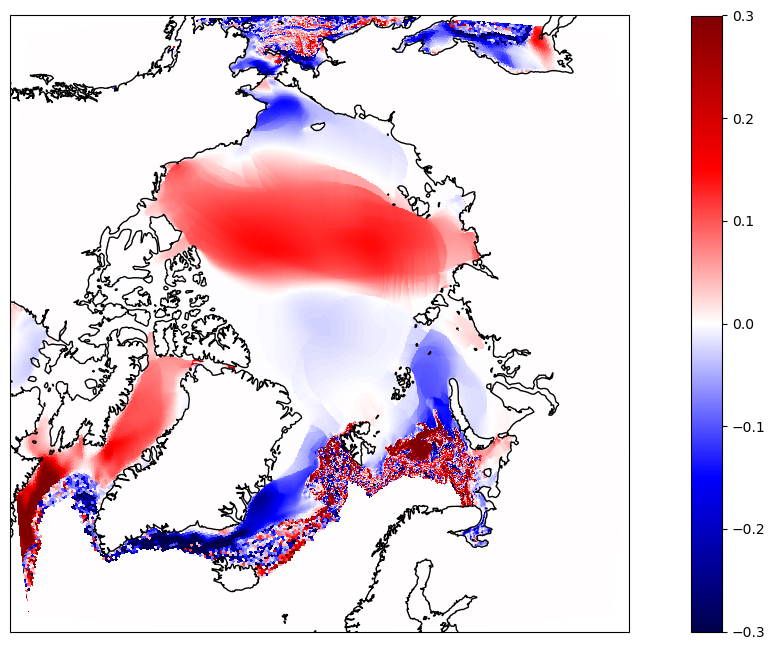

In [23]:
# plot the interpolated data

test = xr.open_dataset(f'data/ice_{year}_nn.nc')

fig = plt.figure(figsize=[16, 8])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines(zorder=3)

im = ax.pcolormesh(test.ULON, test.ULAT,
                   test.U.isel(time=10),
                   cmap = 'seismic',
                   vmin=-0.3, vmax=0.3,
                   transform=ccrs.PlateCarree())
plt.colorbar(im)

[<GeoAxesSubplot:>]

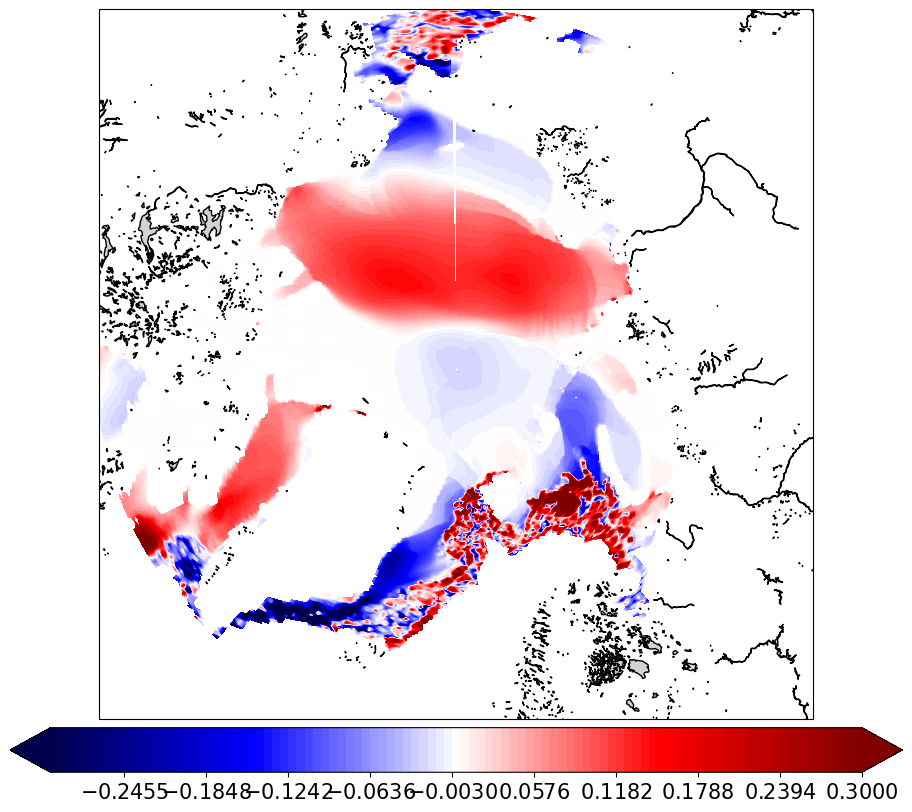

In [13]:
# plot the original data

pf.plot(mesh, u_ice[10,:].values,
        mapproj='np', box=[-180, 180, 60, 90],
        cmap = 'seismic', levels=(-0.3,0.3,100),
       figsize=(10,8))